In [1]:
# Cell 1: Imports (add to top of notebook)

import pandas as pd
import numpy as np
from sklearn.decomposition import PCA


In [2]:
# Cell 2: Load & prepare timestamps (reuse from earlier)

df = pd.read_csv('../files/first_25000_rows.csv')
df['ts_event'] = pd.to_datetime(df['ts_event'])
df = df.sort_values('ts_event').reset_index(drop=True)


In [3]:
# Cell 3: Compute per-level bid/ask flows (reuse compute_flow and loops)

def compute_flow(current_price, prev_price, current_size, prev_size):
    if current_price > prev_price:
        return  current_size
    elif current_price < prev_price:
        return -current_size
    else:
        return current_size - prev_size

levels = list(range(10))
# shift previous quotes
for m in levels:
    df[f'prev_bid_px_{m:02d}'] = df[f'bid_px_{m:02d}'].shift(1)
    df[f'prev_bid_sz_{m:02d}'] = df[f'bid_sz_{m:02d}'].shift(1)
    df[f'prev_ask_px_{m:02d}'] = df[f'ask_px_{m:02d}'].shift(1)
    df[f'prev_ask_sz_{m:02d}'] = df[f'ask_sz_{m:02d}'].shift(1)

# compute flows & per-level OFI
for m in levels:
    df[f'bid_flow_{m}'] = df.apply(
        lambda r: compute_flow(r[f'bid_px_{m:02d}'], r[f'prev_bid_px_{m:02d}'],
                               r[f'bid_sz_{m:02d}'], r[f'prev_bid_sz_{m:02d}']), axis=1)
    df[f'ask_flow_{m}'] = df.apply(
        lambda r: compute_flow(r[f'prev_ask_px_{m:02d}'], r[f'ask_px_{m:02d}'],
                               r[f'prev_ask_sz_{m:02d}'], r[f'ask_sz_{m:02d}']), axis=1)
    df[f'ofi_level_{m}'] = df[f'bid_flow_{m}'] - df[f'ask_flow_{m}']


In [4]:
# Cell 4: Build multi-level OFI matrix & fit PCA

# extract only the per-level OFI columns into a numpy array
ofi_cols = [f'ofi_level_{m}' for m in levels]
multi_ofi = df[ofi_cols].fillna(0).values

# fit PCA on all events, keep only first component
pca = PCA(n_components=1)
pca.fit(multi_ofi)

# raw weights (first PC), then normalize by l1 norm
w1 = pca.components_[0]
w1_norm = w1 / np.sum(np.abs(w1))


In [5]:
# Cell 5: Compute Integrated OFI per event

# projection onto normalized first principal direction
df['ofi_integrated_event'] = multi_ofi.dot(w1_norm)

# inspect weights and a few integrated OFI values
print("Normalized PC1 weights (sum abs = 1):", np.round(w1_norm,4))
df[['ts_event','ofi_integrated_event']].head()


Normalized PC1 weights (sum abs = 1): [0.0322 0.08   0.1392 0.1642 0.136  0.1163 0.0891 0.0918 0.0799 0.0713]


,ts_event,ofi_integrated_event
0,2024-10-21 11:54:29.221064336+00:00,0.000000
1,2024-10-21 11:54:29.223769812+00:00,0.064354
2,2024-10-21 11:54:29.225030400+00:00,0.096531
3,2024-10-21 11:54:29.712434212+00:00,27.838422
4,2024-10-21 11:54:29.764673165+00:00,-27.838422


In [7]:
# Cell 6: Aggregate Integrated OFI to one value per minute

df['minute'] = df['ts_event'].dt.floor('min')
ofi_int_per_minute = (
    df.groupby('minute')['ofi_integrated_event']
      .sum()
      .reset_index()
      .rename(columns={'ofi_integrated_event':'ofi_integrated'})
)

ofi_int_per_minute.head()


,minute,ofi_integrated
0,2024-10-21 11:54:00+00:00,155.483460
1,2024-10-21 11:55:00+00:00,333.370573
2,2024-10-21 11:56:00+00:00,193.156627
3,2024-10-21 11:57:00+00:00,50.647855
4,2024-10-21 11:58:00+00:00,334.468815


<Axes: title={'center': 'Integrated OFI per Minute'}, xlabel='minute'>

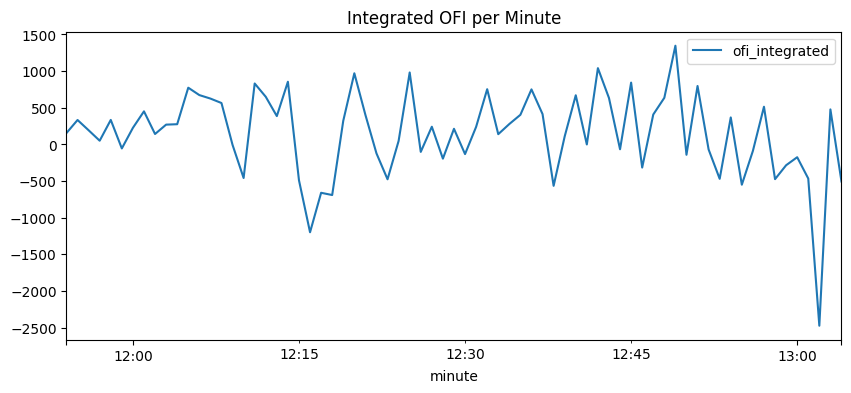

In [8]:
# Cell 7: (Optional) Export or plot

ofi_int_per_minute.to_csv('ofi_integrated_per_minute.csv', index=False)
ofi_int_per_minute.plot(
    x='minute', y='ofi_integrated',
    figsize=(10,4), title='Integrated OFI per Minute'
)
